In [1]:
%matplotlib inline

import random
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from genome.read_fasta import seq_iter
from stream.sketch import CountMinMemory
from Angus.approximation import err_distfinder

Cannot use compiled code


In [39]:
def maxim(lst):
    a = np.inf
    min_found = False
    for pos, i in enumerate(lst):
        if i < a:
            if min_found and i > 1000:
                return pos
            else:
                a = i
        else:
            min_found = True
            a = i
    return 1

def difference(counts1, counts2):
    error_in_error = (np.absolute(np.log(max(1, counts1[1])/max(1, counts2[1]))) + 
                      0.5*np.absolute(np.log(max(1, counts1[2])/max(1, counts2[2]))))
    max1, max2 = maxim(counts1), maxim(counts2)
    error_in_size = (np.absolute(np.log(max(1, counts1[max1 - 1])/max(1, counts2[max2 - 1]))) + 
                     0.5*np.absolute(np.log(max(1, counts1[max1])/max(1, counts2[max2]))) + 
                     0.5*np.absolute(np.log(max(1, counts1[max1 + 1])/max(1, counts2[max2 + 1]))))
    return error_in_error + error_in_size

def total_Variation(counts1, counts2):
    acc = 0
    if len(counts1) < len(counts2):
        acc += sum(counts2[len(counts1):])
    elif len(counts2) < len(counts1):
        acc += sum(counts1[len(counts2):])
    for i in range(1, min(len(counts1), len(counts2))):
        acc += np.abs(counts1[i] - counts2[i])
    return np.log(acc)

def hellinger(counts1, counts2):
    acc = 0
    if len(counts1) < len(counts2):
        acc += sum(counts2[len(counts1):])
    elif len(counts2) < len(counts1):
        acc += sum(counts1[len(counts2):])
    for i in range(1, min(len(counts1), len(counts2))):
        acc += (np.sqrt(counts1[i]) - np.sqrt(counts2[i]))**2
    return np.log(acc)

def read_some_data(amount, size, sketch, reads, klen):
    acc = 0
    for i in reads:
        acc += 1
        size += 80
        for j in range(80):
            kmer = i[j : j + klen]
            sketch.update(kmer)
        if acc >= amount:
            break
    return size, sketch

def make_heatmap_data(errors, sizes, reads):
    heatmap = []
    for size in sizes:
        row = []
        for error in errors:
            row.append(err_distfinder(int(size), reads, 20, error))
        heatmap.append(row)
    return heatmap

def plot_heatmap(data, errors, sizes, counts, diff_measure, prefix=False, label=False):
    numbers = [[diff_measure(counts, x) for x in row] for row in data]
    plt.pcolor(errors, sizes, numbers, cmap='plasma')
    plt.colorbar()
    plt.axis('tight')
    if prefix:
        if label == 'd':
            plt.title('Plot of Peak Difference with ' + prefix + ' variation')
        elif label == 'tv':
            plt.title('Plot of Total Variation with ' + prefix + ' variation')
        elif label == 'h':
            plt.title('Plot of Helliger Distance with ' + prefix + ' variation')
        plt.ylabel(r'$\log_{10}(Genome Size)$')
        plt.xlabel(r'$\log_{10}(Error Rate)$')
        plt.savefig('Angus/figures/' + prefix + '_' + label + '.png')
    plt.show()
    return numbers
    
def make_and_plot_heatmap(errors, sizes, reads, counts):
    center_errors = [(errors[i] + errors[i + 1])/2 for i in range(0, len(errors) - 1)]
    center_sizes = [(sizes[i] + sizes[i + 1])/2 for i in range(0, len(errors) - 1)]
    data = make_heatmap_data(center_errors, center_sizes, reads)
    plot_heatmap(data, errors, sizes, counts)
    
def make_and_plot_loglog_heatmap(errors, sizes, reads, counts):
    center_errors = [(errors[i]*errors[i + 1])**0.5 for i in range(0, len(errors) - 1)]
    center_sizes = [(sizes[i]*sizes[i + 1])**0.5 for i in range(0, len(sizes) - 1)]
    data = make_heatmap_data(center_errors, center_sizes, reads)
    heatmap = plot_heatmap(data, np.log10(errors), np.log10(sizes), counts,
                          difference)
    return heatmap, data

def make_and_plot_all(errors, sizes, reads, counts, prefix=False):
    center_errors = [(errors[i]*errors[i + 1])**0.5 for i in range(0, len(errors) - 1)]
    center_sizes = [(sizes[i]*sizes[i + 1])**0.5 for i in range(0, len(sizes) - 1)]
    data = make_heatmap_data(center_errors, center_sizes, reads)
    heatmap1 = plot_heatmap(data, np.log10(errors), np.log10(sizes), counts,
                          difference, prefix, 'd')
    heatmap2 = plot_heatmap(data, np.log10(errors), np.log10(sizes), counts,
                          total_Variation, prefix, 'tv')
    heatmap3 = plot_heatmap(data, np.log10(errors), np.log10(sizes), counts,
                          hellinger, prefix, 'h')
    return heatmap1, heatmap2, heatmap3, data

In [11]:
data_reads = seq_iter('genome/reads-aunt_00.fa.gz')
klen = 21
sketch = CountMinMemory()
amount = 0

amount, sketch = read_some_data(2*12500, amount, sketch, data_reads, klen)
counts = [x[1] for x in enumerate(np.bincount(sketch.get_feat()))]
num_reads = sum(i*x for i, x in enumerate(counts))

Now that we have generated the data to measure against, we gnerate a 5x5 heatmap over some possible error percentages and genome sizes.

In [12]:
errors = [10**-5, 3.16*10**-5, 10**-4, 3.16*10**-4, 10**-3, 3.16*10**-3, 10**-2, 3.16*10**-2, 10**-1]
genome_sizes = [10**4, 2.15*10**4, (2.15**2)*10**4, 10**5, 2.15*10**5, (2.15**2)*10**5, 10**6]

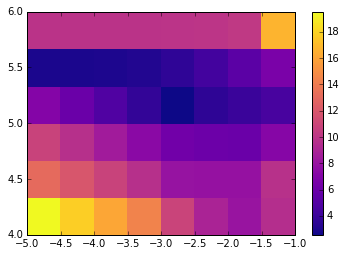

In [7]:
heatmap_info, freq_curves = make_and_plot_loglog_heatmap(errors, genome_sizes, num_reads, counts)

Looking at the heat map we see a central square corresponding to a genome size of $2 \times 10^5$ and an error rate of $10^{-3}$. Hence let us zoom in on this squre to test how smooth the error method is closer up. There is that line along the left half way up but I think this is a feature coming from the coverage. 

In [13]:
close_errors = [10**-4, 2*10**-4, 5*10**-4, 10**-3, 2*10**-3, 5*10**-3, 10**-2]
close_genome_sizes = [10**5, 1.26*10**5, (1.26**2)*(10**5), 2*10**5, 2*1.36*10**5, 2*(1.36**2)*(10**5), 5*10**5]

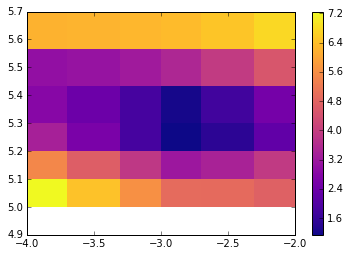

In [9]:
heatmap_info_closer, freq_curves_closer = make_and_plot_loglog_heatmap(close_errors, close_genome_sizes, num_reads, counts)

This shows that the Genome size is close to $2\times 10^5$ and the error rate is around $10^{-3} - 2\times 10^{-3}$. Hence we can zoom in even further.

In [16]:
very_close_errors = [10**-3.1, 10**-3, 10**-2.9, 10**-2.8, 10**-2.7, 10**-2.6, 10**-2.5]
very_close_genome_sizes = [10**5.2, 10**5.225, 10**5.25, 10**5.275, 10**5.3, 10**5.325, 10**5.35, 10**5.375, 10**5.4, 10**5.425]

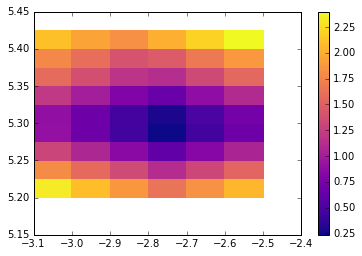

In [11]:
_ = make_and_plot_loglog_heatmap(very_close_errors, very_close_genome_sizes, num_reads, counts)

As can be seen from this heatmap, at a close enough level, the function may not have a unique minimum. That being said I have zoomed in quite far especially on the y axis. Hence if we minimise with random starting locations and average results we will likely get good estimates of the error rate and the genome size. Now let us test this with different coverage. If we deacrease out coverage we get:

In [13]:
data_reads = seq_iter('genome/reads-aunt_00.fa.gz')
klen = 21
sketch = CountMinMemory()
amount = 0

amount, sketch = read_some_data(2*3750, amount, sketch, data_reads, klen)
counts2 = [x[1] for x in enumerate(np.bincount(sketch.get_feat()))]
num_reads2 = sum(i*x for i, x in enumerate(counts2))

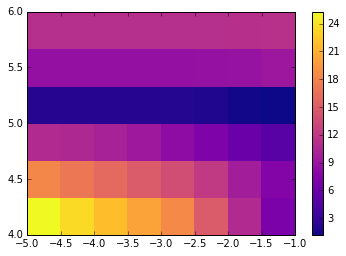

In [14]:
_ = make_and_plot_loglog_heatmap(errors, genome_sizes, num_reads2, counts2)

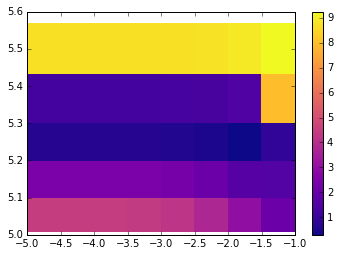

In [22]:
closer_low_cov_genome_sizes = [10**5.01, 1.26*10**5, (1.26**2)*(10**5), 2*10**5, 2*1.36*10**5, 2*(1.36**2)*(10**5)]
_ = make_and_plot_loglog_heatmap(errors, closer_low_cov_genome_sizes, num_reads2, counts2)

This looks a litte worse but that is to be expected. As the coverage lowers, its harder to solve which k-mers are there due to errors. On the other hand, if we increase the converage we would hope that there would be a more obvious minimum.

In [17]:
data_reads = seq_iter('genome/reads-aunt_00.fa.gz')
klen = 21
sketch = CountMinMemory()
amount = 0

amount, sketch = read_some_data(2*18750, amount, sketch, data_reads, klen)
counts3 = [x[1] for x in enumerate(np.bincount(sketch.get_feat()))]
num_reads3 = sum(i*x for i, x in enumerate(counts3))

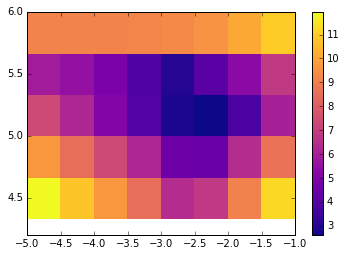

In [18]:
_ = make_and_plot_loglog_heatmap(errors, genome_sizes[1:], num_reads3, counts3)

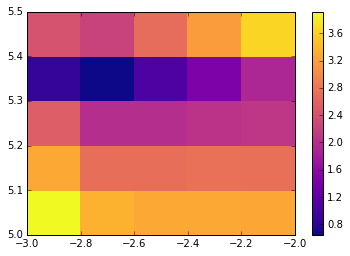

In [25]:
closer_high_cov_errors = [10**-3, 10**-2.8, 10**-2.6, 10**-2.4, 10**-2.2, 10**-2]
closer_high_cov_genome_sizes = [10**5.001, 10**5.1, 10**5.2, 10**5.3, 10**5.4, 10**5.5]
_ = make_and_plot_loglog_heatmap(closer_high_cov_errors, closer_high_cov_genome_sizes, num_reads3, counts3)

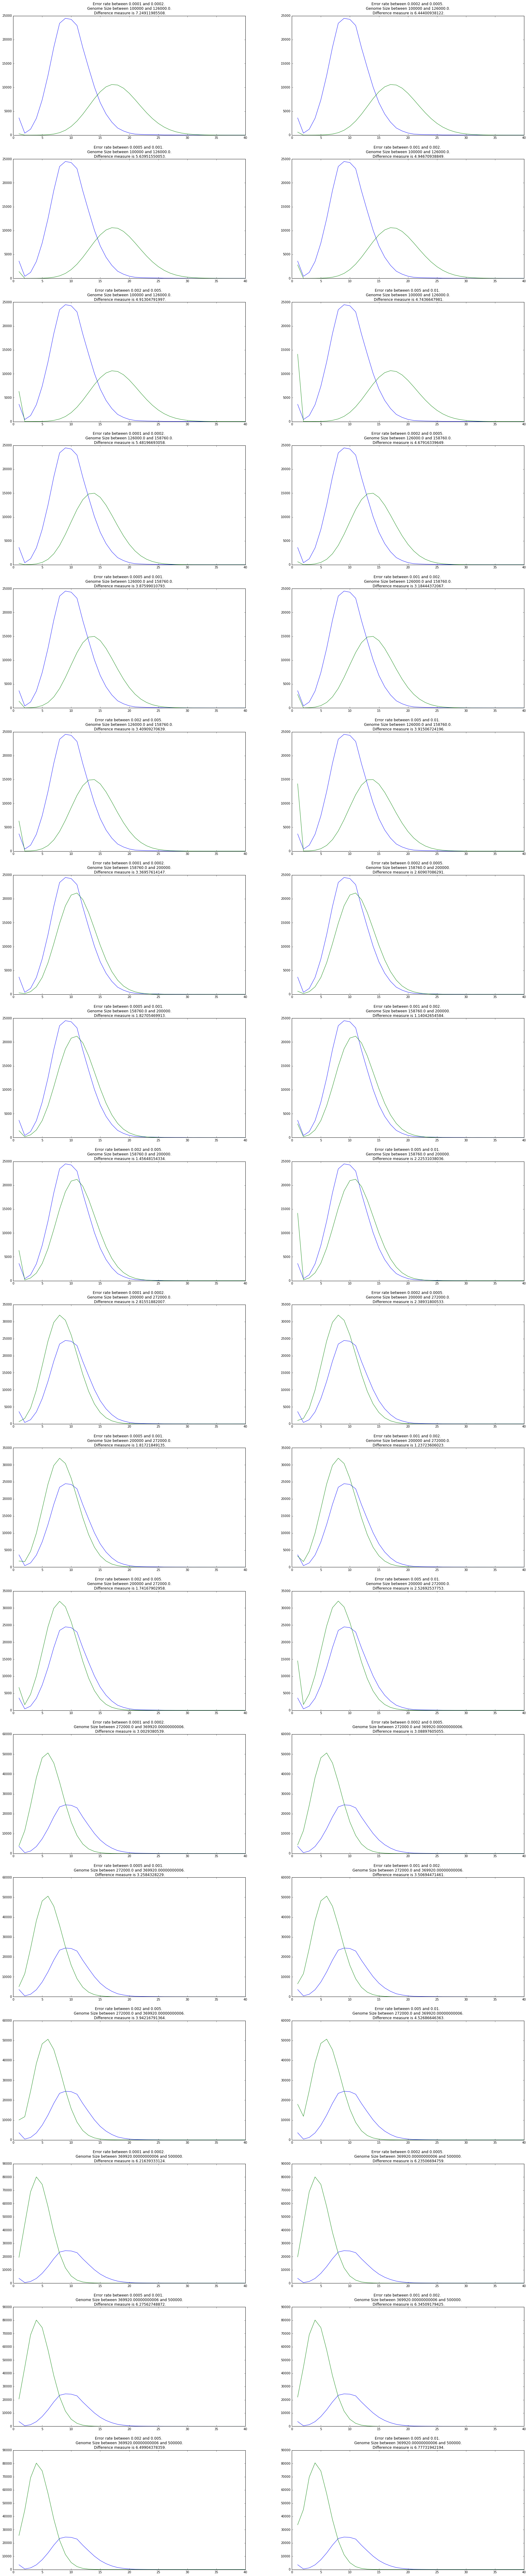

In [107]:
fig, axes = plt.subplots(nrows = 3*(len(close_genome_sizes) - 1), ncols = (len(close_errors) - 1)//3, figsize = (30, 150))

x = [i for i in range(1, len(counts))]

for i in range(len(close_errors) - 1):
    for j in range(len(close_genome_sizes) - 1):
        freq_freq = freq_curves_closer[j][i]
        axes[3*j + i//2][i%2].plot(x, counts[1:], x, freq_freq[1:len(counts)])
        axes[3*j + i//2][i%2].set_title('Error rate between %s and %s. \n Genome Size between %s and %s. \n Difference measure is %s.' 
                                    % (close_errors[i], close_errors[i + 1], close_genome_sizes[j], close_genome_sizes[j + 1], heatmap_info_closer[j][i]))
        
plt.show()

In [108]:
for row in heatmap_info:
    print(['%.3f' % x for x in row])

['13.096', '11.952', '10.805', '9.654', '7.957', '7.903', '7.869', '9.761']
['10.815', '9.671', '8.524', '7.373', '6.224', '6.022', '5.955', '7.135']
['7.095', '5.987', '4.852', '3.705', '2.556', '3.493', '3.983', '4.515']
['2.912', '2.897', '2.962', '3.146', '3.571', '4.314', '5.304', '6.655']
['9.886', '9.887', '9.889', '9.897', '9.923', '10.001', '10.216', '16.701']
['19.434', '19.434', '19.435', '19.437', '19.444', '19.466', '19.532', '19.715']


In [109]:
for row in heatmap_info_closer:
    print(['%.3f' % x for x in row])

['7.249', '6.444', '5.640', '4.947', '4.913', '4.744']
['5.482', '4.679', '3.876', '3.184', '3.409', '3.915']
['3.370', '2.609', '1.827', '1.140', '1.456', '2.225']
['2.816', '2.389', '1.817', '1.237', '1.742', '2.527']
['3.003', '3.089', '3.258', '3.507', '3.942', '4.527']
['6.216', '6.235', '6.276', '6.345', '6.499', '6.777']


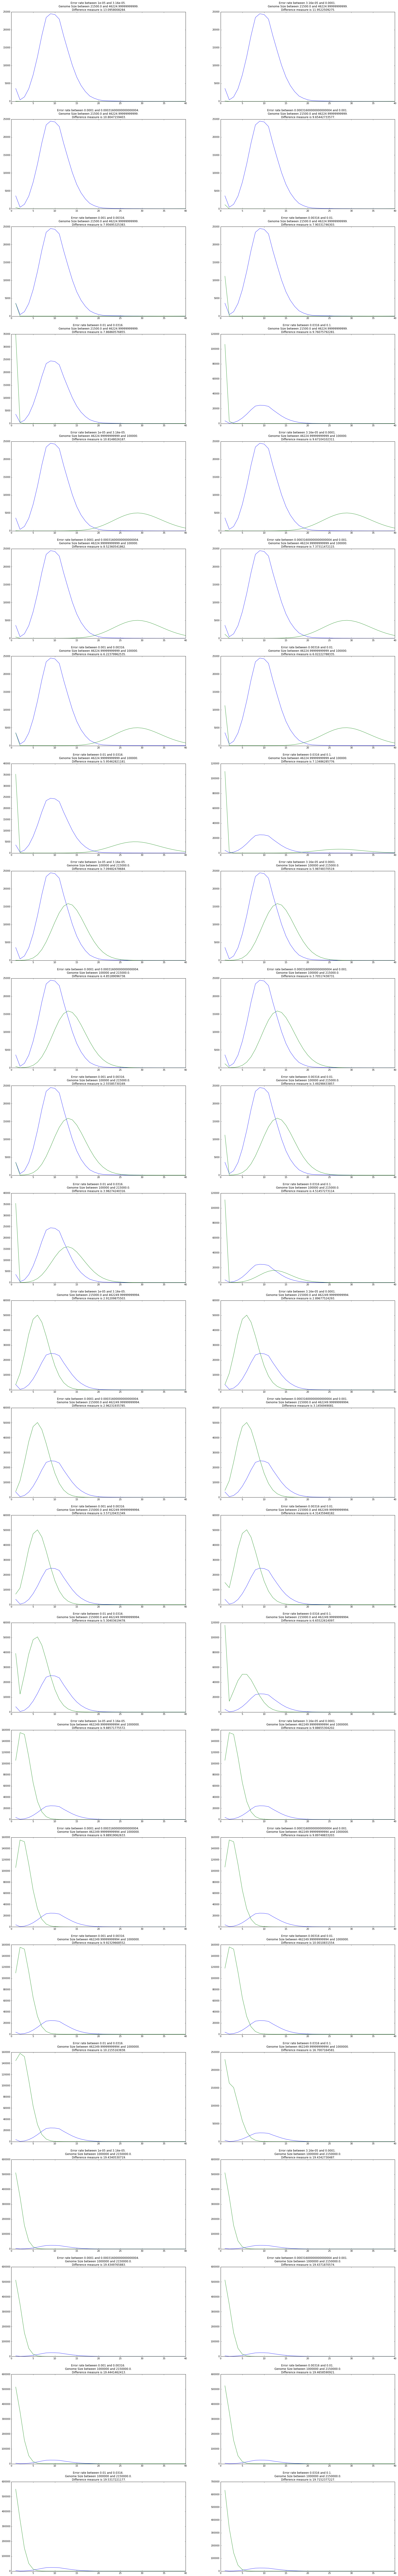

In [112]:
fig, axes = plt.subplots(nrows = 4*(len(genome_sizes) - 1), ncols = (len(errors) - 1)//4, figsize = (30, 200))

x = [i for i in range(1, len(counts))]

for i in range(len(errors) - 1):
    for j in range(len(genome_sizes) - 1):
        freq_freq = freq_curves[j][i]
        axes[4*j + i//2][i%2].plot(x, counts[1:], x, freq_freq[1:len(counts)])
        axes[4*j + i//2][i%2].set_title('Error rate between %s and %s. \n Genome Size between %s and %s. \n Difference measure is %s.' 
                                    % (errors[i], errors[i + 1], genome_sizes[j], genome_sizes[j + 1], heatmap_info[j][i]))
        
plt.show()

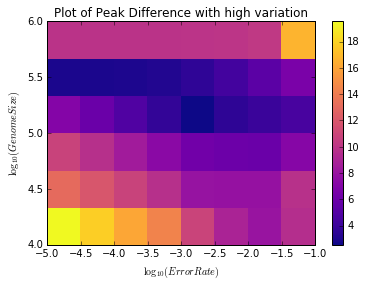

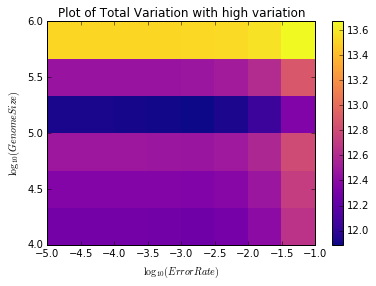

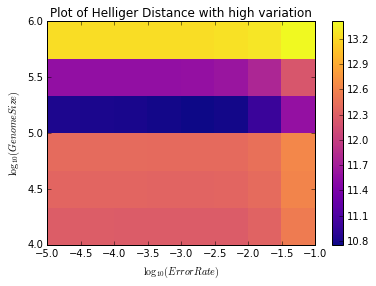

In [40]:
_ = make_and_plot_all(errors, genome_sizes, num_reads, counts, 'high')

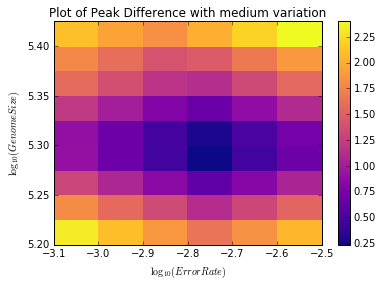

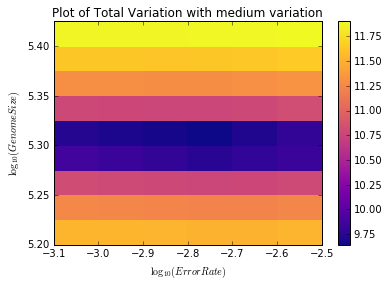

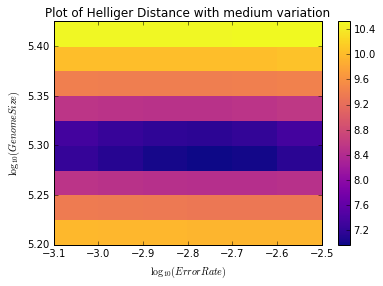

In [41]:
_ = make_and_plot_all(very_close_errors, very_close_genome_sizes,
                      num_reads, counts, 'medium')

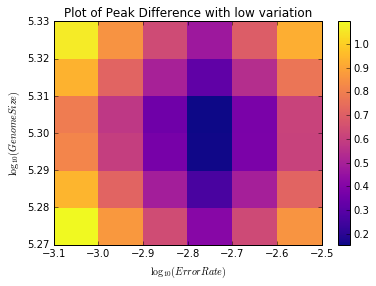

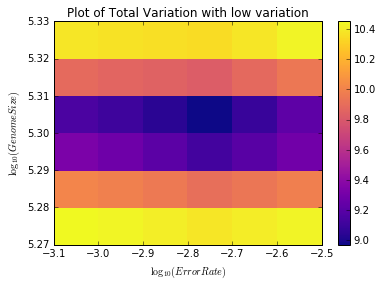

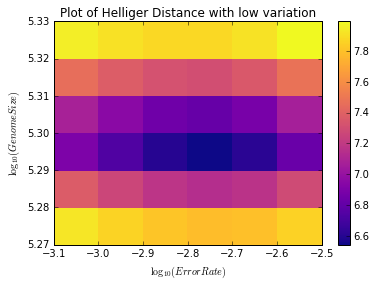

In [42]:
_ = make_and_plot_all(very_close_errors, [10**5.27, 10**5.28, 10**5.29, 10**5.3, 10**5.31, 10**5.32, 10**5.33],
                      num_reads, counts, 'low')